In [215]:
import numpy as np

def pairs_trade(series1, series2, shortWindow, longWindow, tradeThreshold):
    """
    series1 and series2: numpy arrays or pandas series containing the prices of the two assets
    shortWindow (int): the window length of the used to calculate the rolling current ratio
    longWindow (int): the window length of the used to calculate the rolling mean and standard deviation of the ratio
    tradeThreshold (float): the z-score (abs value) above which we would trade
    """
    ratio = series1/series2
    currentRatio = ratio.rolling(shortWindow).mean()
    meanRatio = ratio.rolling(longWindow).mean()
    stdRatio = ratio.rolling(longWindow).std()
    zScores = (currentRatio - meanRatio)/stdRatio
    
    capital = 0
    pos1 = 0
    pos2 = 0

    for day in range(ratio.shape[0] - 1):
        if zScores[day] < - tradeThreshold: #buy spread
            pos1 += 1
            pos2 += - meanRatio[day]
            capital += meanRatio[day] * series2[day] - series1[day]
        elif zScores[day] > tradeThreshold: #sell spread
            pos1 += -1
            pos2 += meanRatio[day]
            capital += series1[day] - meanRatio[day] * series2[day]
    #clear the positions on the last day
    capital += pos1 * series1[-1] + pos2 * series2[-1]
    pos1, pos2 = 0, 0
    return capital

def pairs_trade2(series1, series2, lookWindow, tradeThreshold):
    """
    series1 and series2: numpy arrays or pandas series containing the prices of the two assets
    lookWindow (int): the window length of the used to calculate the rolling mean and standard deviation of the ratio
    tradeThreshold (float): the z-score (abs value) above which we would trade
    """
    regr = linear_model.LinearRegression(fit_intercept=False)
    s1 = series1.values.reshape(-1,1)
    s2 = series2.values.reshape(-1,1)
    regr.fit(s1, s2)
    
    spread = pd.DataFrame(s1 * regr.coef_ - s2, index=series1.index)
    
    rollSpreadMean = spread.rolling(lookWindow).mean()
    rollSpreadStd = spread.rolling(lookWindow).std()
    rollSpreadZ = (spread - rollSpreadMean) / rollSpreadStd
    
    pnls = np.zeros(spread.shape[0]-1)
    capital = 0
    pos1 = 0
    pos2 = 0

    for day in range(spread.shape[0] - 1):
        if rollSpreadZ.values[day] < - tradeThreshold: #buy spread
            pos1 += 1
            pos2 += - spread.values[day]
            capital += spread.values[day] * series2[day] - series1[day]
        elif rollSpreadZ.values[day] > tradeThreshold: #sell spread
            pos1 += -1
            pos2 += spread.values[day]
            capital += series1[day] - spread.values[day] * series2[day]
        pnls[day] = capital
        
    #clear the positions on the last day
    capital += pos1 * series1[-1] + pos2 * series2[-1]
    
    pos1, pos2 = 0, 0
    return capital, pnls, rollSpreadZ

In [78]:
from pandas_datareader import data

series1 = data.get_data_yahoo(('GLD'), start='2010-03-01', end='2021-02-28').loc[:, 'Adj Close']
series2 = data.get_data_yahoo(('GDX'), start='2010-03-01', end='2021-02-28').loc[:, 'Adj Close']

In [79]:
import matplotlib.pyplot as plt
plt.style.use('grayscale')

from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept=False)
s1 = series1.values.reshape(-1,1)
s2 = series2.values.reshape(-1,1)
regr.fit(s1, s2)
regr.coef_

array([[0.23424212]])

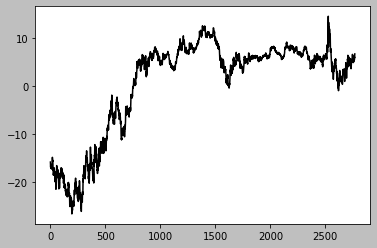

In [80]:
import pandas as pd

spread = pd.DataFrame(s1 * regr.coef_ - s2)
plt.plot(spread)

In [113]:
pairs_trade(series1, series2, 10, 50, 1.5)

-499.1507724514895

In [185]:
capital, pnls, zs = pairs_trade2(series1, series2, 250, 2)

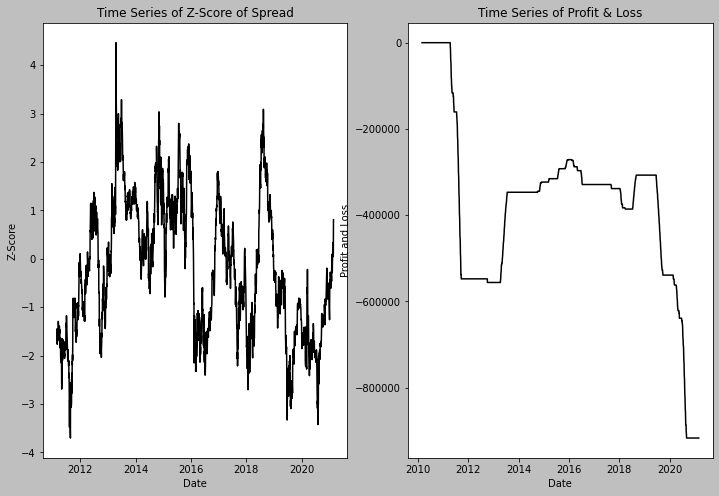

In [210]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Time Series of Z-Score of Spread")
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.plot(zs.index, zs.values)
    
plt.subplot(1, 2, 2)
plt.title("Time Series of Profit & Loss")
plt.xlabel("Date")
plt.ylabel("Profit and Loss")
plt.plot(series1.index[:-1], pnls)

plt.savefig('pairs_charts.png')

In [188]:
series1.index

DatetimeIndex(['2010-03-01', '2010-03-02', '2010-03-03', '2010-03-04',
               '2010-03-05', '2010-03-08', '2010-03-09', '2010-03-10',
               '2010-03-11', '2010-03-12',
               ...
               '2021-02-12', '2021-02-16', '2021-02-17', '2021-02-18',
               '2021-02-19', '2021-02-22', '2021-02-23', '2021-02-24',
               '2021-02-25', '2021-02-26'],
              dtype='datetime64[ns]', name='Date', length=2769, freq=None)

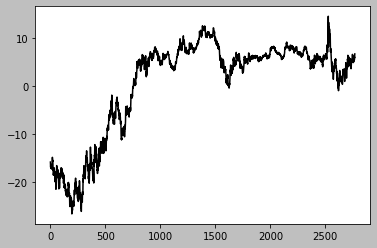

In [180]:
plt.plot(spread)

In [209]:
zs.values